# Clssifier Model for True and Fake news

Reference Notebook : https://www.kaggle.com/snanilim/100-accuracy-is-this-title-fake-or-real

# Import Necessary packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string

import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Path to the datasets
real_data = pd.read_csv('/content/drive/My Drive/AP Hack/datasets/True.csv')
fake_data = pd.read_csv('/content/drive/My Drive/AP Hack/datasets/Fake.csv')

# Basic EDA

In [ ]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
real_data['target'] = 1
fake_data['target'] = 0 

In [ ]:
fake_data.tail()

,title,text,subject,date,target
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [ ]:
combine_data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
combine_data.tail()

,title,text,subject,date,target
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


Text(0.5, 1.0, 'Data distribution of fake and real data')

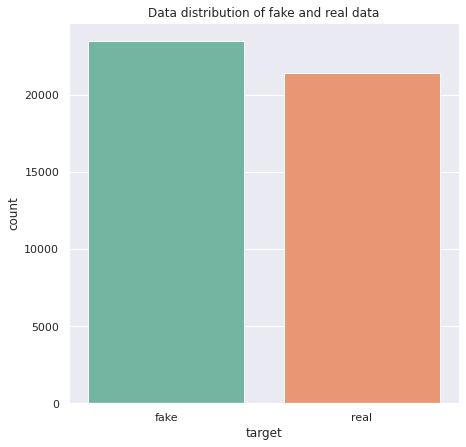

In [ ]:
plt.figure(figsize=(7, 7))
sns.set(style="darkgrid")

color = sns.color_palette("Set2")
ax = sns.countplot(x="target", data=combine_data, palette=color)

ax.set(xticklabels=['fake', 'real'])

plt.title("Data distribution of fake and real data")

In [ ]:
combine_data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

# Data Cleaning

In [ ]:
import re

In [ ]:
def clean_train_data(x):
    text = x
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub(r'http\S+', '', text)
    text = re.sub('\n', '', text)
    return text

In [ ]:
clean_combine_data = combine_data.copy()
clean_combine_data['text'] = combine_data.text.apply(lambda x : clean_train_data(x))
clean_combine_data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters the head of a conservative...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people will be...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters the special counsel invest...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geo...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,seattlewashington reuters president donald tr...,politicsNews,"December 29, 2017",1


In [ ]:
clean_combine_data.tail()

,title,text,subject,date,target
44893,McPain: John McCain Furious That Iran Treated ...,century wire says as reported earlier this w...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,century wire says it s a familiar theme whene...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,patrick henningsen century wireremember when...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,century wire says al jazeera america will go ...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,century wire says as predicted in its new ye...,Middle-east,"January 12, 2016",0


# StopWord Removal

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
eng_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def remove_eng_stopwords(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [word for word in token_text if word not in eng_stopwords]
    join_text = ' '.join(remove_stop)
    return join_text

In [ ]:
stopword_combine_data = clean_combine_data.copy()
stopword_combine_data['text'] = clean_combine_data.text.apply(lambda x : remove_eng_stopwords(x))
stopword_combine_data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters head conservative republica...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people allowed ...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters special counsel investigati...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geor...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,seattlewashington reuters president donald tru...,politicsNews,"December 29, 2017",1


# Modeling

In [ ]:
model_data = stopword_combine_data.copy()

In [ ]:
model_data['combine_text'] = model_data['subject'] + " " + model_data['title'] + " " + model_data['text']
del model_data['title']
del model_data['subject']
del model_data['date']
del model_data['text']
model_data.head()

,target,combine_text
0,1,"politicsNews As U.S. budget fight looms, Repub..."
1,1,politicsNews U.S. military to accept transgend...
2,1,politicsNews Senior U.S. Republican senator: '...
3,1,politicsNews FBI Russia probe helped by Austra...
4,1,politicsNews Trump wants Postal Service to cha...


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(model_data['combine_text'], model_data['target'], random_state=0)

# Vectorizing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)

In [ ]:
X_vec_test = vec_train.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [ ]:
model = LogisticRegression()
model.fit(X_vec_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predicted_value = model.predict(X_vec_test)

In [ ]:
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9985562606683752
